In [2]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')


In [3]:
paths = []
labels = []
genders = []
# Use os.walk to walk through the directory structure
for dirname, _, filenames in os.walk(r'../data'):
    for filename in filenames:
        if filename == '.DS_Store':
            continue  # Skip this file
        # Construct the full file path
        full_path = os.path.join(dirname, filename)
        paths.append(full_path)
        
        # Extract label and gender from the directory name
        # Assumes the structure is data/label_gender/filename

        folder_name = os.path.basename(dirname)
        label = folder_name
        # print(folder_name)
        emotion = label.split('_')[0]
        labels.append(emotion.lower())
        genders.append(str(folder_name).lower())


# Create a DataFrame with the collected data
df = pd.DataFrame({
    'speech': paths,
    'label': labels,
    'label2': genders
})

# Display the first few rows of the DataFrame to verify
df.head()

,speech,label,label2
0,../data\Angry_Female\anger_xn_1.wav,angry,angry_female
1,../data\Angry_Female\anger_xn_10.wav,angry,angry_female
2,../data\Angry_Female\anger_xn_11.wav,angry,angry_female
3,../data\Angry_Female\anger_xn_12.wav,angry,angry_female
4,../data\Angry_Female\anger_xn_13.wav,angry,angry_female


# EDA

In [6]:
eda = df
eda['gender'] = eda['label2'].apply(lambda x: x.split('_')[1])
eda.head()

,speech,label,label2,gender
0,../data\Angry_Female\anger_xn_1.wav,angry,angry_female,female
1,../data\Angry_Female\anger_xn_10.wav,angry,angry_female,female
2,../data\Angry_Female\anger_xn_11.wav,angry,angry_female,female
3,../data\Angry_Female\anger_xn_12.wav,angry,angry_female,female
4,../data\Angry_Female\anger_xn_13.wav,angry,angry_female,female


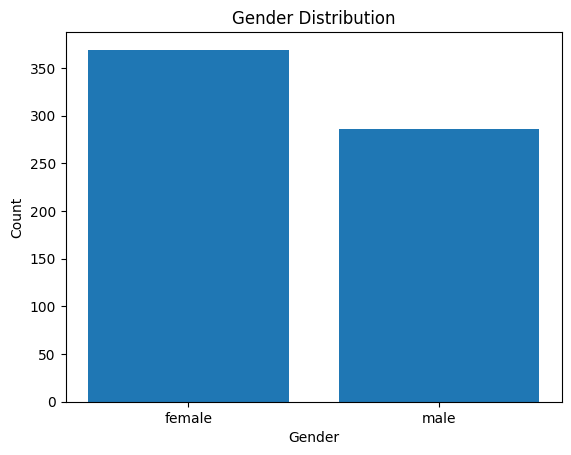

In [8]:
import matplotlib.pyplot as plt

gender_counts = eda['gender'].value_counts()

# Create a bar chart
plt.bar(gender_counts.index, gender_counts)

# Add labels and title
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')

# Display the plot
plt.show()

# Feature Engineering

In [7]:
from sklearn.preprocessing import OneHotEncoder

def extract_mfcc(filename):
    y, sr = librosa.load(filename, duration=3, offset=0.5)
    mfcc = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T, axis=0)
    # print(mfcc)
    return mfcc

def extract_chroma(filename):
    y, sr = librosa.load(filename)
    chroma = np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0)
    return chroma

def extract_spectral_contrast(filename):
    y, sr = librosa.load(filename)
    contrast = np.mean(librosa.feature.spectral_contrast(y=y, sr=sr).T, axis=0)
    return contrast

def extract_tonnetz(filename):
    y, sr = librosa.load(filename)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr).T, axis=0)
    return tonnetz

def processData(df):
    # mfcc
    mfcc_columns = ['mfcc_' + str(i) for i in range(1, 41)]
    mfcc_df = pd.DataFrame(df['speech'].apply(lambda x: extract_mfcc(x)).tolist(), columns=mfcc_columns)
    new_df = pd.concat([df, mfcc_df], axis=1)

    # chroma 
    chroma_columns = ['chroma_' + str(i) for i in range(1, 13)]
    chroma_df = pd.DataFrame(df['speech'].apply(lambda x: extract_chroma(x)).tolist(), columns=chroma_columns)
    new_df = pd.concat([new_df, chroma_df], axis=1)

    # spectral_contrast
    spectral_columns = ['spectral_' + str(i) for i in range(1, 8)]
    spectral_df = pd.DataFrame(df['speech'].apply(lambda x: extract_spectral_contrast(x)).tolist(), columns=spectral_columns)
    new_df = pd.concat([new_df, spectral_df], axis=1)

    # tonnetz
    tonnetz_columns = ['tonnetz_' + str(i) for i in range(1, 7)]
    tonnetz_df = pd.DataFrame(df['speech'].apply(lambda x: extract_tonnetz(x)).tolist(), columns=tonnetz_columns)
    new_df = pd.concat([new_df, tonnetz_df], axis=1)
    # print(df)
    # enc = OneHotEncoder()
    # y = enc.fit_transform(df[['label']])
    # y = y.toarray()
    # print(y.shape)
    return new_df

In [8]:
data = processData(df)

In [9]:
# print(data.head())
print(data.shape)

(655, 68)


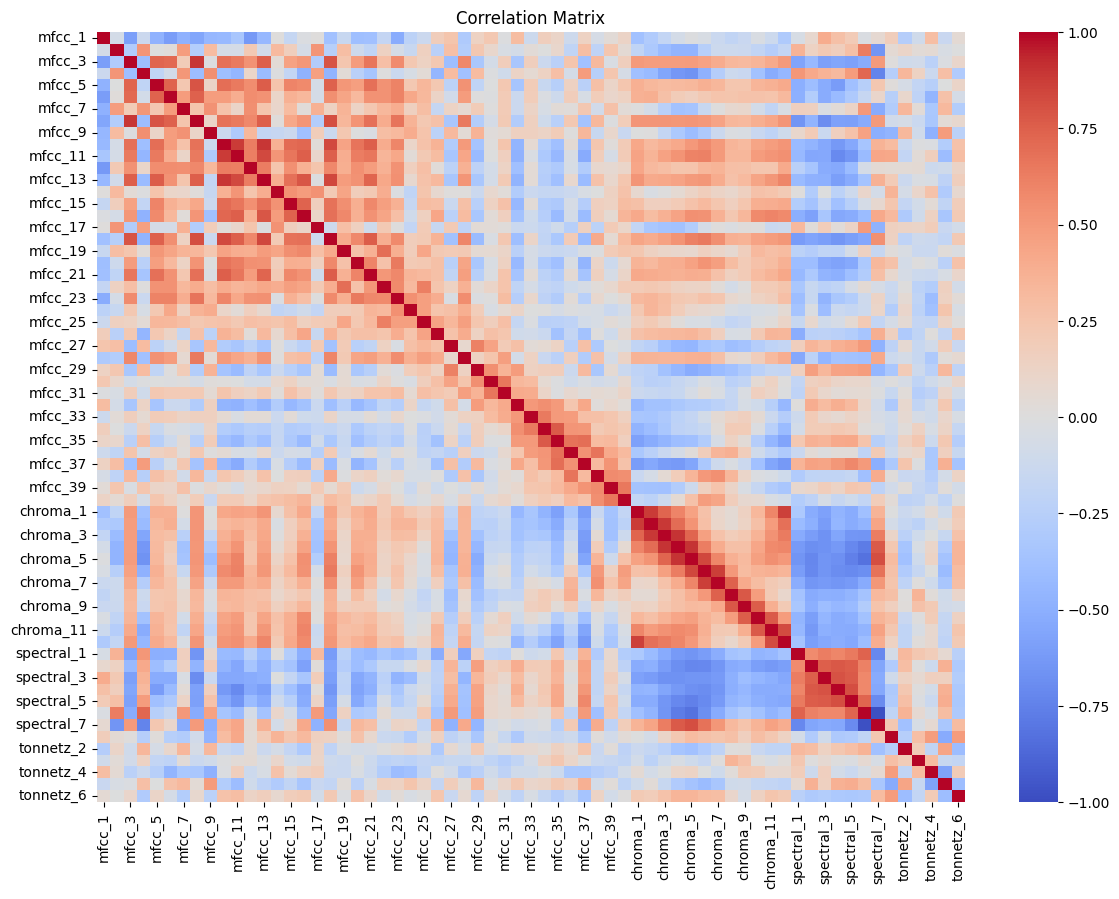

In [11]:
correlation_matrix = data.drop(['speech', 'label', 'label2'], axis=1).corr()
# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

In [14]:
correlation_matrix = data[data.drop(['speech', 'label', 'label2'], axis=1).columns].corr()
pairs = []
for i in range(correlation_matrix.shape[0]):
    for j in range(i+1, correlation_matrix.shape[1]):
        if correlation_matrix.iloc[i, j] > 0.75 or correlation_matrix.iloc[i, j] < -0.75:
            pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

high_corr_df = pd.DataFrame(pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])
high_corr_set = set(high_corr_df['Feature 2'])

dropped_data = data.drop(columns=[col for col in data.columns if col in high_corr_set])
dropped_data.head()

,speech,label,label2,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,chroma_1,chroma_8,spectral_1,spectral_2,tonnetz_1,tonnetz_2,tonnetz_3,tonnetz_4,tonnetz_5,tonnetz_6
0,../data\Angry_Female\anger_xn_1.wav,angry,angry_female,-494.275452,134.563019,-25.692625,44.874004,-6.713496,-20.871096,13.515034,...,0.402734,0.503801,31.923484,17.956310,0.059400,0.014392,0.118363,0.036899,0.047293,-0.028096
1,../data\Angry_Female\anger_xn_10.wav,angry,angry_female,-489.237396,95.241463,-6.124708,45.021778,-1.017477,-12.822159,15.770240,...,0.409627,0.526004,29.469380,16.135760,-0.010318,0.051561,0.045706,-0.027530,-0.004011,-0.008055
2,../data\Angry_Female\anger_xn_11.wav,angry,angry_female,-520.552795,101.389832,-10.185467,41.562035,3.115262,-10.974776,11.411966,...,0.627573,0.540234,28.944638,13.118379,0.005677,-0.002739,0.116942,0.065897,-0.005532,-0.037391
3,../data\Angry_Female\anger_xn_12.wav,angry,angry_female,-490.044342,127.468536,-25.104696,38.669411,-12.717003,-19.364574,20.204561,...,0.454550,0.499391,29.633752,15.092322,0.042003,0.046887,0.056951,0.035294,0.028878,-0.020695
4,../data\Angry_Female\anger_xn_13.wav,angry,angry_female,-475.499969,120.513458,-31.929777,47.917557,-6.103209,-19.414783,9.694456,...,0.350280,0.550284,30.638892,15.346131,0.019974,0.033962,0.098241,0.080186,0.020042,-0.017513


In [15]:
high_corr_df

,Feature 1,Feature 2,Correlation
0,mfcc_3,mfcc_8,0.892260
1,mfcc_3,mfcc_13,0.756054
2,mfcc_3,mfcc_18,0.794097
3,mfcc_5,mfcc_8,0.791473
4,mfcc_5,mfcc_13,0.761114
5,mfcc_8,mfcc_13,0.754753
6,mfcc_8,mfcc_18,0.814147
7,mfcc_10,mfcc_11,0.876969
8,mfcc_10,mfcc_13,0.894345
9,mfcc_10,mfcc_18,0.829424


In [16]:
high_corr_df[high_corr_df['Feature 2'].str.contains('tonnetz')]

,Feature 1,Feature 2,Correlation


In [17]:
high_corr_df[high_corr_df['Feature 2'].str.contains('chroma')]

,Feature 1,Feature 2,Correlation
18,chroma_1,chroma_2,0.878733
19,chroma_1,chroma_12,0.865792
20,chroma_2,chroma_3,0.885635
21,chroma_3,chroma_4,0.898515
22,chroma_4,chroma_5,0.901121
25,chroma_5,chroma_6,0.840049
29,chroma_6,chroma_7,0.867936
30,chroma_8,chroma_9,0.777899
31,chroma_9,chroma_10,0.758275
32,chroma_10,chroma_11,0.766005


In [18]:
high_corr_df[high_corr_df['Feature 2'].str.contains('spectral')]

,Feature 1,Feature 2,Correlation
23,chroma_4,spectral_6,-0.780355
24,chroma_4,spectral_7,0.766721
26,chroma_5,spectral_5,-0.752563
27,chroma_5,spectral_6,-0.823989
28,chroma_5,spectral_7,0.816672
34,spectral_2,spectral_3,0.756604
35,spectral_2,spectral_4,0.776799
36,spectral_2,spectral_5,0.759097
37,spectral_3,spectral_4,0.799536
38,spectral_3,spectral_5,0.769417


In [20]:
dropped_data.columns

Index(['speech', 'label', 'label2', 'mfcc_1', 'mfcc_2', 'mfcc_3', 'mfcc_4',
       'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_9', 'mfcc_10', 'mfcc_12', 'mfcc_14',
       'mfcc_15', 'mfcc_17', 'mfcc_19', 'mfcc_20', 'mfcc_22', 'mfcc_23',
       'mfcc_24', 'mfcc_25', 'mfcc_26', 'mfcc_27', 'mfcc_28', 'mfcc_29',
       'mfcc_30', 'mfcc_31', 'mfcc_32', 'mfcc_33', 'mfcc_34', 'mfcc_36',
       'mfcc_37', 'mfcc_38', 'mfcc_39', 'mfcc_40', 'chroma_1', 'chroma_8',
       'spectral_1', 'spectral_2', 'tonnetz_1', 'tonnetz_2', 'tonnetz_3',
       'tonnetz_4', 'tonnetz_5', 'tonnetz_6'],
      dtype='object')

### Chroma
Chroma features are highly correlated to each other.

### Spectral
Spectral features are highly correlated to each other.


In [22]:
dropped_data.to_csv('IS4242 Data.csv', index=False)